In [24]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


# Getting Familiar with Image Data

In [5]:
# Setting up the path to the files
path_images = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/uint8/rs19_val/'

Labels are: [ 1  5  7  8  9 10 12 15 17]
The image was the length of 1920
The image was the height of 1080


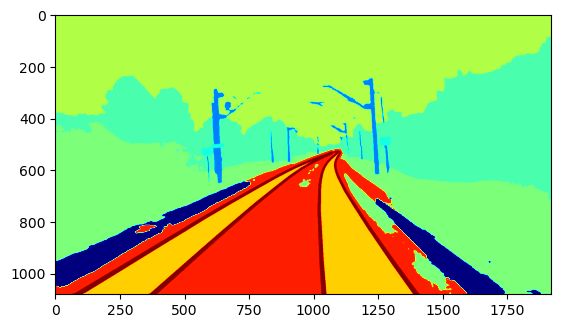

In [6]:
# Read a Random Image 
temp_mask = cv2.imread(path_images+'rs08171.png')

# Print out mask labels of this image
label = np.unique(temp_mask[:,:,0])
print("Labels are:", label)

# Size X - Length of image 
size_x = temp_mask.shape[1]
print("The image was the length of", size_x)

# Size Y - Height of Image 
size_y = temp_mask.shape[0]
print("The image was the height of", size_y)

# Show image 
plt.imshow(temp_mask[:,:,0], cmap='jet')

# Reading the Data

In [9]:
# Setting up the directory for the files 
path_images = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/jpgs/rs19_val/'
path_masks = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/uint8/rs19_val/' 

# Setting up a breaker for test run 
breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    breaker += 1
    if filename.endswith('.jpg'):
        image = cv2.imread(path_images+filename)
        image = image[:1056,:,:] #divisible by 32 because of UNET requirements
        mask = cv2.imread(path_masks+filename[:7]+'.png')
        mask = mask[:1056,:,:]
        for layer in range(len(mask[0,0,:])):
            mask[:int(size_y/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
                #this is because one hot encoder can only deal with 0 and 1 if there is 2 labels
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==100:
        break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

image:  (100, 1056, 1920, 3)
mask:  (100, 1056, 1920)
image:  (100, 1056, 1920, 3)
mask:  (100, 1056, 1920, 1)
unique labels in mask [0 1]


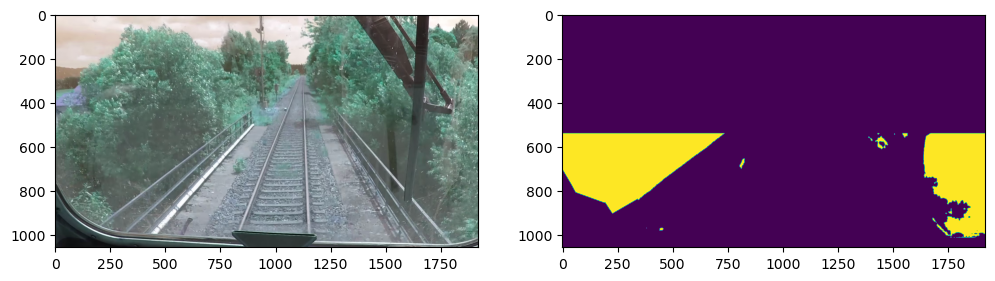

In [21]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()


# Split of Data

In [27]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [28]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [29]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

2022-11-12 21:59:43.722114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


44920640/44920640 [==============================] - 10s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

In [30]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=10,
                        epochs=2,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/2
8/8 [==============================] - 2010s 246s/step - loss: 0.5106 - iou_score: 0.0766 - mse: 0.1636 - val_loss: 4.8878 - val_iou_score: 8.2154e-04 - val_mse: 0.0722
Epoch 2/2
4/8 [==============>...............] - ETA: 14:00 - loss: 0.3186 - iou_score: 0.0233 - mse: 0.0832